Chaining: Chaining Parametric To Inversion
==========================================

Before reading this example, make sure you have read the `autolens_workspace/notebooks/imaging/modeling/chaining/api.py`
example script, which describes phase chaining and details the API for this.

In this example, we chain two searches, where:

 - The first search models the lens galaxy's mass as an `EllipticalIsothermal` and the source galaxy's light as an
      `EllipticalSersic`.
      
 - The second search models the lens galaxy's mass an an `EllipticalPoerLaw` and the source galaxy's light as an
      `EllipticalSersic`.

The `EllipticalPower` is a general form of the `EllipticalIsothermal` and it has one addition parameter relative to the
`EllipticalIsothermal`, the `slope`. This controls the internal mass distriibution of the mass profile, whereby:

 - A higher slope concentrates more mass in the central regions of the `MassProfile` relative to the outskirts. 
 - A lower slope shallows the inner mass distribution reducing its density relative to the outskirts. 

By allowing a `MassProfile` to vary its inner distribution, the non-linear parameter space of the lens model becomes 
significantly more complex, creating a notable degeneracy between the mass model`s mass normalization, ellipticity
and slope. This proves challenging to sample in an efficient and robust manner, especially if our initial samples are
not initalized so as to start sampling in the high likelhood regions of parameter space.

We can use prior passing to perform this initialization!  The `EllipticalIsothermal` profile corresponds to an 
`EllipticalPowerLaw` with a slope = 2.0. Thus, we can first fit an `EllipticalIsothermal` model in a non-linear 
parameter space that does not have the strong degeneracy between mass, ellipticity and axis-ratio, which will 
provide an efficient and robust fit. 

Search 2 can then fit the `EllipticalPowerLaw`, using prior passing to initialize robust models for both the lens 
`Galaxy`'s mass *and* the source galaxy's light.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


As per usual, load the `Imaging` data, create the `Mask2D` and plot them. In this strong lensing dataset:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalPowerLaw`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

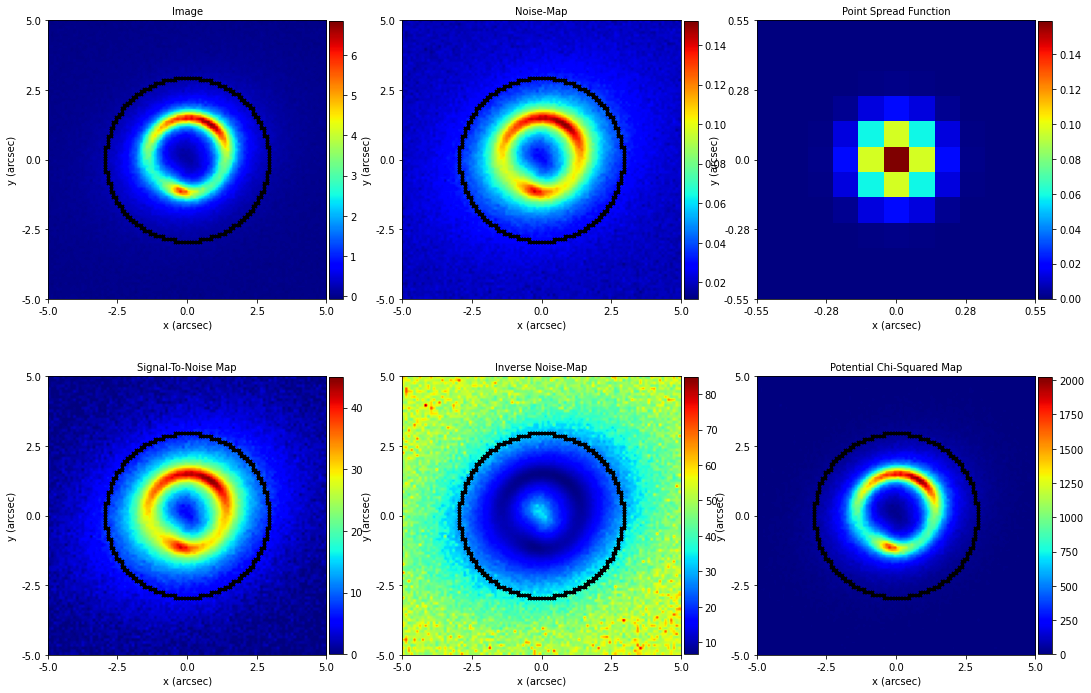

In [2]:
dataset_name = "mass_power_law__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Model__

We compose our lens model using `GalaxyModel` objects, which represent the galaxies we fit to our data. In this 
example our lens model is:

 - An `EllipticalIsothermal` `MassProfile` for the lens galaxy's mass [5 parameters] in search 1.
 - An `EllipticalSersic` `LightProfile` for the source galaxy's light [7 parameters] in search 1.
 - An `EllipticalPowerLaw` `MassProfile` for the lens galaxy's mass (6 parameters) in search 2.
 - An `EllipticalSersic` `LightProfile` for the source galaxy's light [7 parameters] in search 2.

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=12 and N=13
for searches 1 and 2 respectively..

In [3]:
lens = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllipticalIsothermal)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllipticalSersic)

__Settings__

You should be familiar with the `SettingsPhaseImaging` object from other example scripts, if not checkout the beginner
examples and `autolens_workspace/notebooks/imaging/modeling/customize/settings.py`

In [4]:
settings = al.SettingsPhaseImaging()

__Search__

You should be familiar with non-linear searches from other example scripts if not checkout the beginner examples
and `autolens_workspace/notebooks/imaging/modeling/customize/non_linear_searches.py`.

In this example, we omit the PriorPasser and will instead use the default values used to pass priors in the config 
file `autolens_workspace/config/non_linear/nest/DynestyStatic.ini`

In [5]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", "chaining", "sie_to_power_law"),
    name="phase[1]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/examples/chaining/sie_to_power_law/lens_power_law__source_bulge/phase[1]`.

In [6]:
phase1 = al.PhaseImaging(
    search=search,
    settings=settings,
    galaxies=af.Collection(lens=lens, source=source),
)

phase1_result = phase1.run(dataset=imaging, mask=mask)

INFO:root:phase[1] already completed, skipping non-linear search.


Before reading on to search 2, you may wish to inspect the results of the search 1 model-fit to ensure the fast
non-linear search has provided a reasonably accurate lens model.

__Model Chaining__

We use the results of search 1 to create the `GalaxyModel` components that we fit in search 2.

The term `model` below passes the lens and source models as model-components that are to be fitted
for by the non-linear search. In other chaining examples, we'll see other ways to pass prior results.

Because we change the `MassProfile` from an `EllipticalIsothermal` to an `EllipticalPowerLaw`, we cannot simply pass the
mass model above. Instead, we pass each individual parameter of the `EllipticalIsothermal` model, leaving the slope
to retain its default `UniformPrior` which has a lower_limit=1.5 and upper_limit=3.0.

In [7]:
mass = af.Model(al.mp.EllipticalPowerLaw)

mass.centre = phase1_result.model.galaxies.lens.mass.centre
mass.elliptical_comps = phase1_result.model.galaxies.lens.mass.elliptical_comps
mass.einstein_radius = phase1_result.model.galaxies.lens.mass.einstein_radius

lens = af.Model(al.Galaxy, redshift=0.5, mass=mass)

source = af.Model(al.Galaxy, redshift=1.0, bulge=phase1_result.model.galaxies.source.bulge)

__Search__

In search 2, we use the nested sampling algorithm `Dynesty` again.

The `name` and `path_prefix` below specify the path where results are stored in the output folder:  

 `/autolens_workspace/output/examples/chaining/sie_to_power_law/lens_power_law__source_bulge/phase[2]`.

In [8]:
search = af.DynestyStatic(
    path_prefix=path.join("imaging", "chaining", "sie_to_power_law"),
    name="phase[2]",
    n_live_points=50,
)

__Phase__

We can now combine the model, settings and search to create and run a phase, fitting our data with the lens model.

Note how the `lens` passed to this phase was set up above using the results of search 1!

In [9]:
phase2 = al.PhaseImaging(
    search=search,
    settings=settings,
    galaxies=af.Collection(lens=lens, source=source),
)

phase2.run(dataset=imaging, mask=mask)

INFO:root:phase[2] already completed, skipping non-linear search.


__Wrap Up__

In this example, we passed used prior passing to initialize a lens mass model as an `EllipticalIsothermal` and 
passed its priors to then fit the more complex `EllipticalPowerLaw`. model. This removed difficult-to-fit degeneracies
from the non-linear parameter space in search 1, providing a more robust and efficient model-fit.

__Pipelines__

The next level of PyAutoLens uses `Pipelines`, which chain together multiple searches to perform complex lens 
modeling in robust and efficient ways. Pipelines which fit a power-law, for example:

 `autolens_workspace/pipelines/no_lens_light/mass_power_law__source_inversion.py`

Exploit our ability to first model the lens's mass using an `EllipticalIsothermal` and then switch to an 
`EllipticalPowerLaw`, to ensure more efficient and robust model-fits!